# BentoML Example:  Deploy to Google Cloud Run

[BentoML](http://bentoml.ai) is an open source framework for building, shipping and running machine learning services. It provides high-level APIs for defining an ML service and packaging its artifacts, source code, dependencies, and configurations into a production-system-friendly format that is ready for deployment.

This notebook demonstrates how to use BentoML to deploy a machine learning model as a REST API endpoint to Google Cloud run. For this demo, we are using the [Sentiment Analysis with Scikit-learn](https://github.com/bentoml/BentoML/blob/master/examples/sklearn-sentiment-clf/sklearn-sentiment-clf.ipynb) example, using dataset from [Sentiment140](http://help.sentiment140.com/for-students/).

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=nb&ea=open&el=official-example&dt=deploy-with-google-cloudrun)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install -I bentoml
!pip install sklearn pandas numpy

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

import bentoml

# Prepare Dataset

In [3]:
%%bash

if [ ! -f ./trainingandtestdata.zip ]; then
    wget -q http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
    unzip -n trainingandtestdata.zip
fi

In [4]:
columns = ['polarity', 'tweetid', 'date', 'query_name', 'user', 'text']
dftrain = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      header = None,
                      encoding ='ISO-8859-1')
dftest = pd.read_csv('testdata.manual.2009.06.14.csv',
                     header = None,
                     encoding ='ISO-8859-1')
dftrain.columns = columns
dftest.columns = columns

# Model Training

In [5]:
sentiment_lr = Pipeline([
                         ('count_vect', CountVectorizer(min_df = 100,
                                                        ngram_range = (1,1),
                                                        stop_words = 'english')), 
                         ('lr', LogisticRegression())])
sentiment_lr.fit(dftrain.text, dftrain.polarity)

/usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('count_vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=100,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [6]:
Xtest, ytest = dftest.text[dftest.polarity!=2], dftest.polarity[dftest.polarity!=2]
print(classification_report(ytest,sentiment_lr.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       177
           4       0.82      0.86      0.84       182

   micro avg       0.83      0.83      0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359



In [7]:
sentiment_lr.predict([Xtest[0]])

array([4])

#  BentoService for model serving

In [8]:
%%writefile sentiment_lr_model.py
import pandas as pd
import bentoml
from bentoml.artifact import PickleArtifact
from bentoml.handlers import DataframeHandler

@bentoml.artifacts([PickleArtifact('sentiment_lr')])
@bentoml.env(pip_dependencies=["scikit-learn", "pandas"])
class SentimentLRModel(bentoml.BentoService):
    
    @bentoml.api(DataframeHandler, typ='series')
    def predict(self, series):
        """
        predict expects pandas.Series as input
        """        
        return self.artifacts.sentiment_lr.predict(series)

Overwriting sentiment_lr_model.py


# Save BentoService to file bundle

In [9]:
from sentiment_lr_model import SentimentLRModel

# Initialize bentoML model with artifacts

bento_model = SentimentLRModel()
bento_model.pack('sentiment_lr', sentiment_lr)

# Save bentoML model to directory
saved_path = bento_model.save()

# print the directory containing exported model archive (prefixed with model name and version)
print(saved_path)

[2019-12-17 15:35:01,002] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.3. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2019-12-17 15:35:01,004] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.3. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml

no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.5.3+24.ga700564.dirty
creating BentoML-0.5.3+24.ga700564.dirty/BentoML.egg-info
creating BentoML-0.5.3+24.ga700564.dirty/bentoml
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/artifact
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/bundler
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/cli
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/clipper
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/configuration
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/deployment
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/deployment/aws_lambda
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/deployment/sagemaker
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/handlers
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/migrations
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/migrations/versions
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/proto
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/repository
creating BentoML-0.5.3+24.ga700564.dirty/bentoml/server
creat

copying bentoml/repository/metadata_store.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/repository
copying bentoml/server/__init__.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/bento_api_server.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/bento_sagemaker_server.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/gunicorn_config.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/gunicorn_server.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/utils.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server
copying bentoml/server/static/swagger-ui-bundle.js -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server/static
copying bentoml/server/static/swagger-ui.css -> BentoML-0.5.3+24.ga700564.dirty/bentoml/server/static
copying bentoml/utils/__init__.py -> BentoML-0.5.3+24.ga700564.dirty/bentoml/utils
copying bentoml/utils/cloudpickle.py -> BentoML-0.5.3+24.ga700564

# Load BentoService from saved bundle

In [6]:
import bentoml

# Load exported bentoML model archive from path
bento_model = bentoml.load(saved_path)

# Call predict on the restored sklearn model
bento_model.predict(pd.Series(["hello", "hi"]))

[2019-12-17 10:50:20,968] WARNING - Module `sentiment_lr_model` already loaded, using existing imported module.


/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.3 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


array([4, 4])

In [7]:
bento_tag = '{name}:{version}'.format(name=bento_model.name, version=bento_model.version)

# Deploy BentoService with Google Cloud Run

1. Install Google Cloud SDK and CLI
https://cloud.google.com/sdk/install

2. Create new project with `gcloud`

In [8]:
!gcloud projects create sentiment-gcloud-run

Create in progress for [https://cloudresourcemanager.googleapis.com/v1/projects/sentiment-gcloud-run].
Waiting for [operations/cp.7580966240072066179] to finish...done.              
Enabling service [cloudapis.googleapis.com] on project [sentiment-gcloud-run]...
Operation "operations/acf.3d6ba408-4f5e-4859-923d-40a491b663a4" finished successfully.


In [12]:
!gcloud config set project sentiment-gcloud-run

Updated property [core/project].


**Make sure enable cloud run API on Google cloud console**
https://console.cloud.google.com/

In [10]:
!gcloud components update


All components are up to date.


In [20]:
%cd {saved_path}

/Users/bozhaoyu/bentoml/repository/SentimentLRModel/20191216231343_AEA027


*Upload docker image to Google Container registry*

In [22]:
!gcloud builds submit --tag gcr.io/sentiment-gcloud-run/sentiment

Creating temporary tarball archive of 80 file(s) totalling 8.8 MiB before compression.
Uploading tarball of [.] to [gs://sentiment-gcloud-run_cloudbuild/source/1576610370.18-1acde23d92024652b4d6c72df4b6a8e9.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/sentiment-gcloud-run/builds/12df8469-1242-4662-a858-e5f6b8809184].
Logs are available at [https://console.cloud.google.com/gcr/builds/12df8469-1242-4662-a858-e5f6b8809184?project=185885650434].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "12df8469-1242-4662-a858-e5f6b8809184"

FETCHSOURCE
Fetching storage object: gs://sentiment-gcloud-run_cloudbuild/source/1576610370.18-1acde23d92024652b4d6c72df4b6a8e9.tgz#1576610373095149
Copying gs://sentiment-gcloud-run_cloudbuild/source/1576610370.18-1acde23d92024652b4d6c72df4b6a8e9.tgz#1576610373095149...
/ [1 files][  4.8 MiB/  4.8 MiB]                                                
Operation completed over 1 objects/4.8 MiB.       

Selecting previously unselected package binutils.
Preparing to unpack .../03-binutils_2.31.1-16_amd64.deb ...
Unpacking binutils (2.31.1-16) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../04-libc-dev-bin_2.28-10_amd64.deb ...
Unpacking libc-dev-bin (2.28-10) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../05-linux-libc-dev_4.19.67-2+deb10u2_amd64.deb ...
Unpacking linux-libc-dev:amd64 (4.19.67-2+deb10u2) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.28-10_amd64.deb ...
Unpacking libc6-dev:amd64 (2.28-10) ...
Selecting previously unselected package libisl19:amd64.
Preparing to unpack .../07-libisl19_0.20-2_amd64.deb ...
Unpacking libisl19:amd64 (0.20-2) ...
Selecting previously unselected package libmpfr6:amd64.
Preparing to unpack .../08-libmpfr6_4.0.2-1_amd64.deb ...
Unpacking libmpfr6:amd64 (4.0.2-1) ...
Selecting previously unselected package libmpc3:amd

asn1crypto-1.2.0     | 162 KB    | ########## | 100% 
cffi-1.13.2          | 225 KB    | ########## | 100% 
openssl-1.1.1d       | 3.7 MB    | ########## | 100% 
ca-certificates-2019 | 132 KB    | ########## | 100% 
setuptools-42.0.2    | 646 KB    | ########## | 100% 
conda-4.8.0          | 2.8 MB    | ########## | 100% 
sqlite-3.30.1        | 1.9 MB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - numpy
    - pip
    - scipy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blas-1.0                   |              mkl           6 KB
    intel-openmp-2019.4        |              243         729 KB
    libgfortran-ng-7.3.0       |       hdf63c60_0        1006 KB

  Created wheel for alembic: filename=alembic-1.3.2-py2.py3-none-any.whl size=151128 sha256=36872acdc17b397586990ad013da9c6b2721049f5fd745f926354d17bc15bead
  Stored in directory: /root/.cache/pip/wheels/5c/66/53/e0633382ac8625ab1c099db6a290d1b6b24f849a4666a57105
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.3.12-cp37-cp37m-linux_x86_64.whl size=1219996 sha256=97cd7337d8f01cee4772b101748de4ddf2caf50b57a769efe820c72dbd988923
  Stored in directory: /root/.cache/pip/wheels/ee/33/44/0788a6e806866ae2e246d5cd841d07498a46bcb3f3c42ea5a4
  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-cp37-none-any.whl size=41402 sha256=c5db3fb1918a082bd93e1fac2dd855d693ee413865af14afbf55b4f867a3ee19
  Stored in directory: /root/.cache/pip/wheels/1c/54/34/fd47cd9b308826cc4292b54449c1899a30251ef3b506bc91ea
  Created wheel for cerberus: filename=Cerberus-1.3.2-cp37-none-any.whl size=54336 sha256=34c243ebb16f00a83904a27f48c561312ed61cf69a661e43292ae5c51a90bbed
  Stored in directory:

Processing ./bundled_pip_dependencies/BentoML-0.5.3+21.g49ab5c9.dirty.tar.gz
  Created wheel for BentoML: filename=BentoML-0.5.3+21.g49ab5c9.dirty-cp37-none-any.whl size=487095 sha256=7fedc26c485c58ce6eb2e96ab9e86e8a7d111b7cf246f64e8739ecf9b59fe774
  Stored in directory: /root/.cache/pip/wheels/96/8e/c1/fd4e802c0650a986605c3193cb96453400366ae796fe27c1d7
Successfully built BentoML
  Found existing installation: python-dateutil 2.8.1
    Uninstalling python-dateutil-2.8.1:
      Successfully uninstalled python-dateutil-2.8.1
  Found existing installation: BentoML 0.5.3
    Uninstalling BentoML-0.5.3:
      Successfully uninstalled BentoML-0.5.3
Removing intermediate container 30bf1ea37f7b
 ---> bee079a51740
Step 11/12 : RUN if [ -f /bento/setup.sh ]; then /bin/bash -c /bento/setup.sh; fi
 ---> Running in 1e2e61499d14
Removing intermediate container 1e2e61499d14
 ---> 55e978a0485e
Step 12/12 : CMD ["bentoml serve-gunicorn /bento"]
 ---> Running in 3ede5ea26123
Removing intermediate contai

3c2124396dda: Pushed
9c2abf6244f1: Pushed
5d22ba7b3671: Pushed
992b825a2c90: Pushed
2db44bce66cd: Layer already exists
db9833946e7b: Pushed
5215cb249b79: Pushed
3ee7190fd43a: Pushed
82142827bbb1: Pushed
latest: digest: sha256:eacca2a47d914da06c874f56efb84bb35ee08fb0c305850a4952f1bd1c7723cd size: 2225
DONE
--------------------------------------------------------------------------------

ID                                    CREATE_TIME                DURATION  SOURCE                                                                                          IMAGES                                           STATUS
12df8469-1242-4662-a858-e5f6b8809184  2019-12-17T19:19:33+00:00  4M51S     gs://sentiment-gcloud-run_cloudbuild/source/1576610370.18-1acde23d92024652b4d6c72df4b6a8e9.tgz  gcr.io/sentiment-gcloud-run/sentiment (+1 more)  SUCCESS


## Deploy the container image to Google Cloud Run

1. Go into your Google Cloud Console, select project sentiment-gcloud-run and navigate to CloudRun page
2. Click `Create Service` on the top navigation bar.
3. In the Create Cloud Run service page:
    * Select container image URL from the selection menu
    * Choose Allow Unauthenitcated invocations from the Authentication section
    * Expand Show Optional Revision Settings
        - Change Container Port from 8080 to 5000

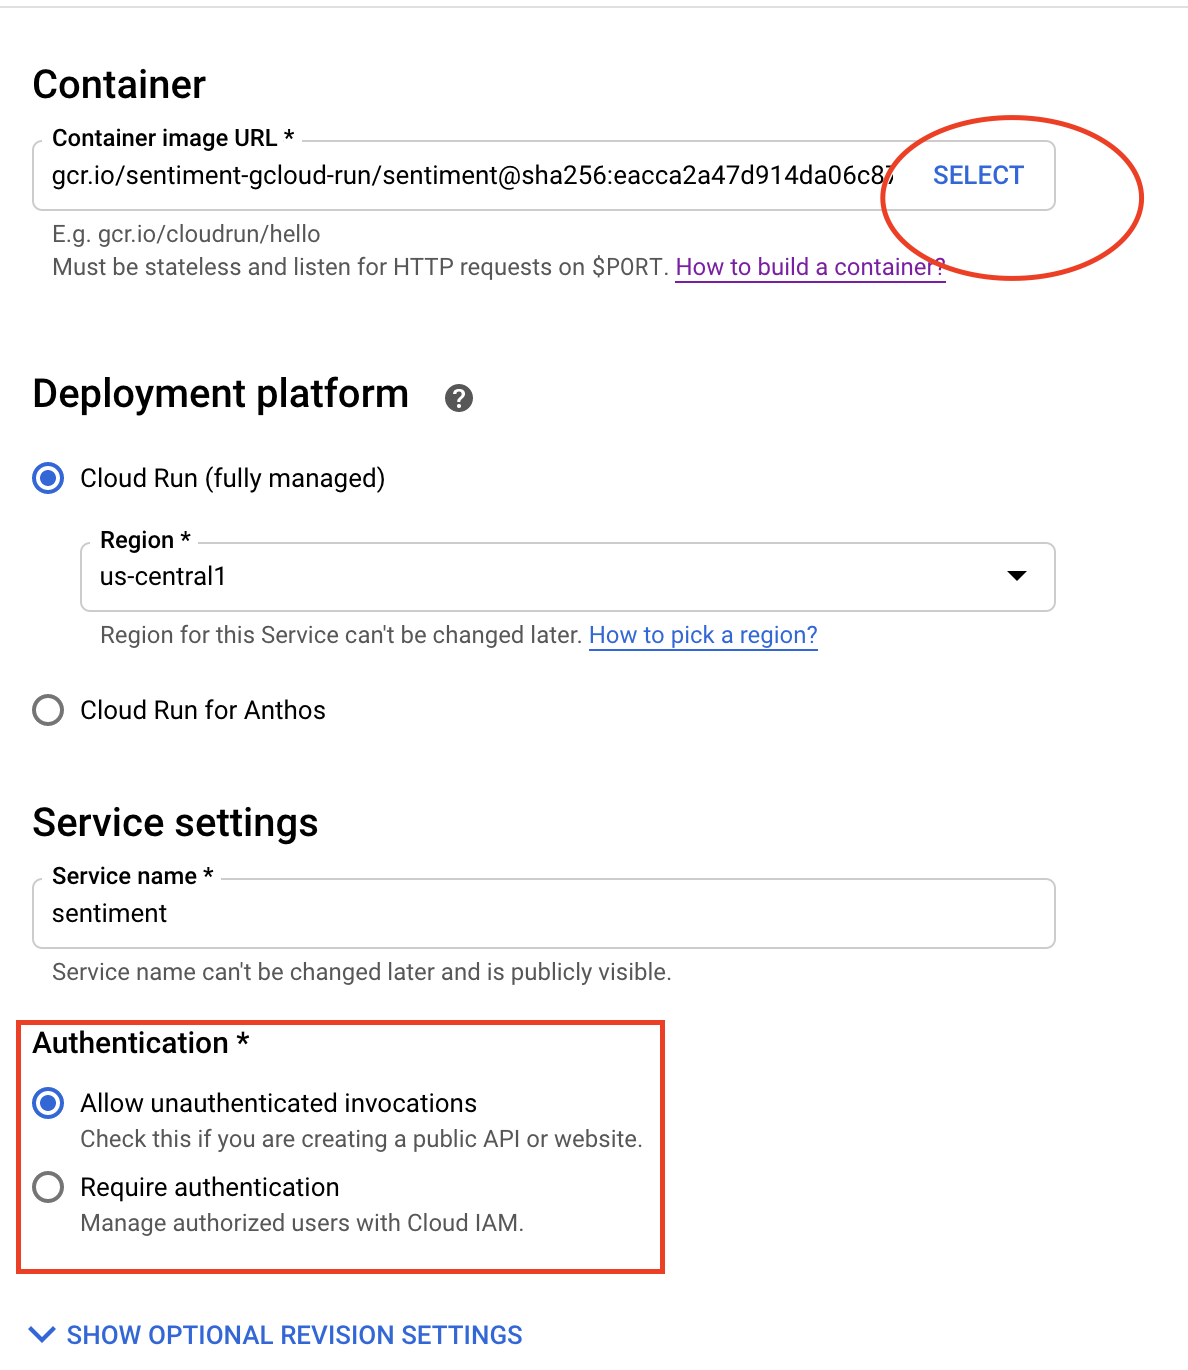
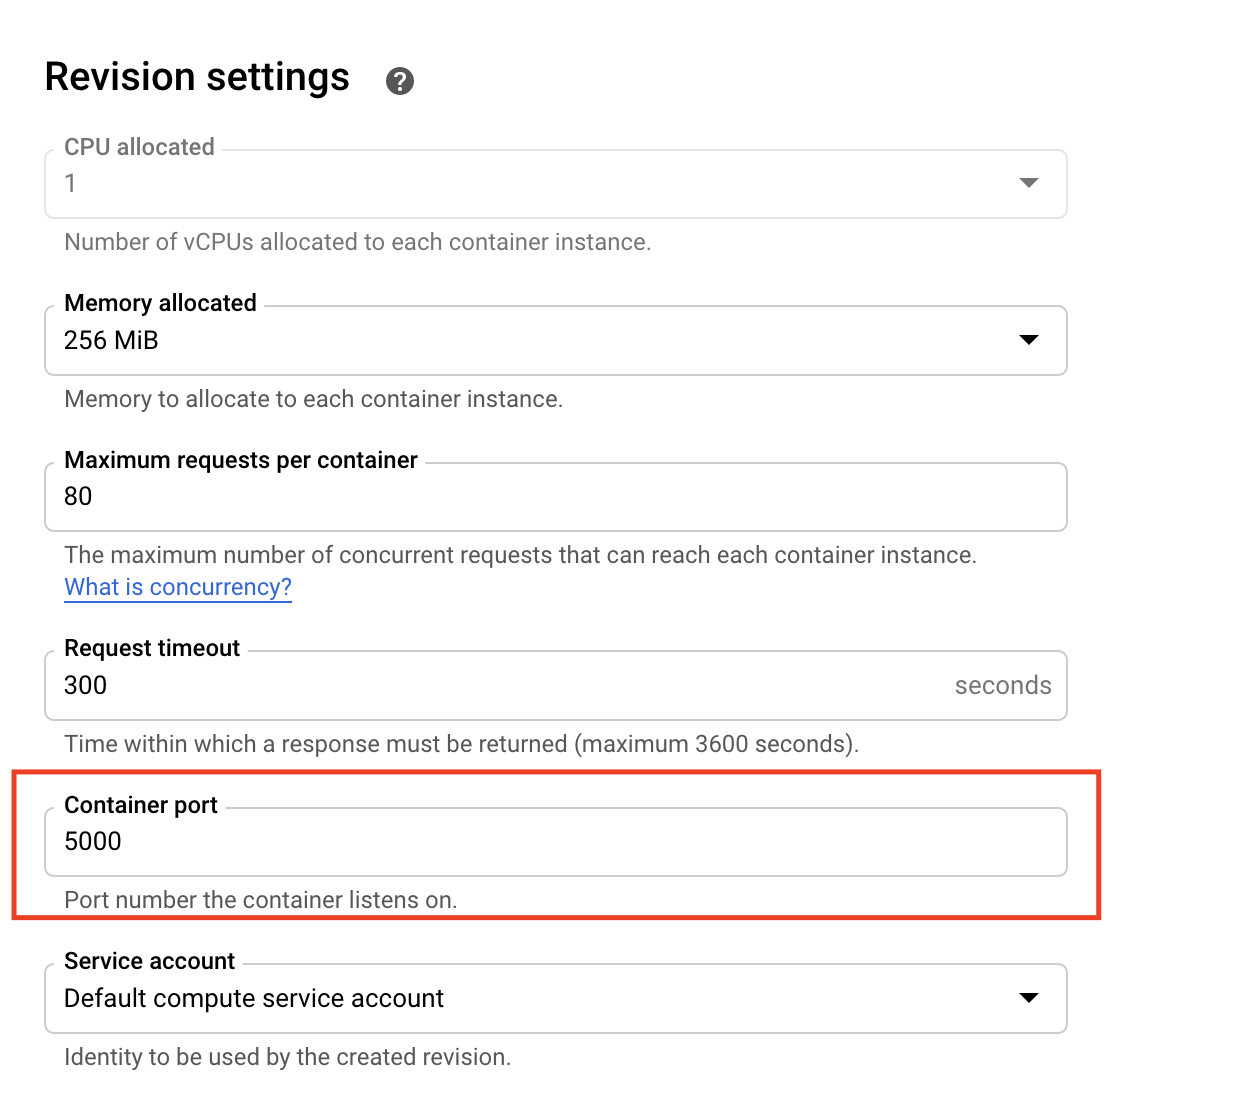

### Test deployed Cloud Run service

After successful deployment, You can find the service URL at the top of the page. Use that in the next cell's `curl` call to test the service with sample data

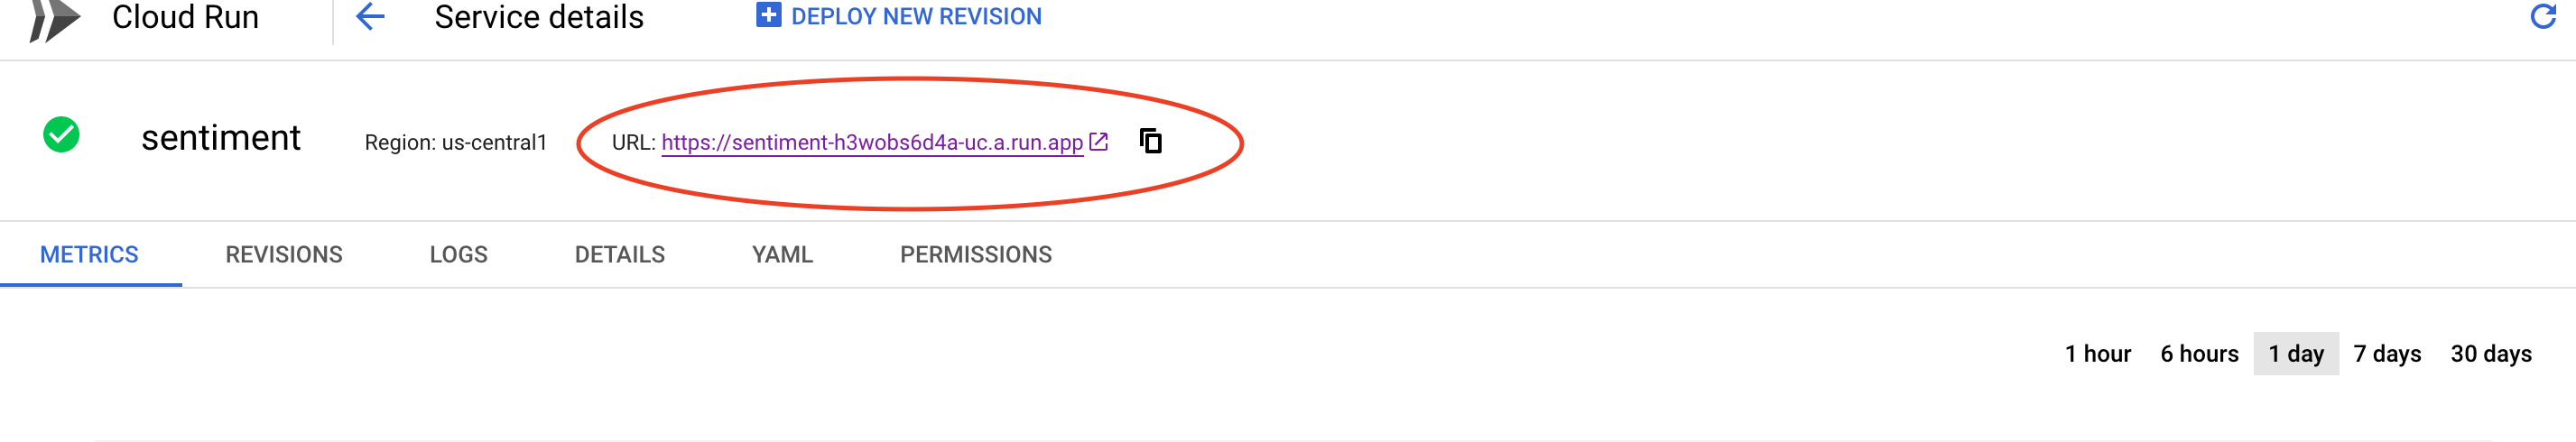

In [36]:
!curl -X \
POST "https://sentiment-h3wobs6d4a-uc.a.run.app/predict" \
--header "Content-Type: application/json" \
-d '["good movie", "bad food"]'

[4, 0]

## Clean up deployed service on Google Cloud Run


1. In the Google Cloud Console, go to the manage resources page
2. In the project list, select the project we just deployed and click the `delete` icon
3. In the dialogtype the projectID `sentiment-gcloud-run` and then click Shut down to delete the project